In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from ModelTrainer import ModelTrainer

In [18]:
data = pd.read_csv("./data/Question4.csv")
data = data.drop(columns=['id'])

In [19]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [21]:
nan_counts = data.isna().sum()
nan_counts

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [22]:
correlation_matrix = data.select_dtypes(exclude=["object"]).corr()

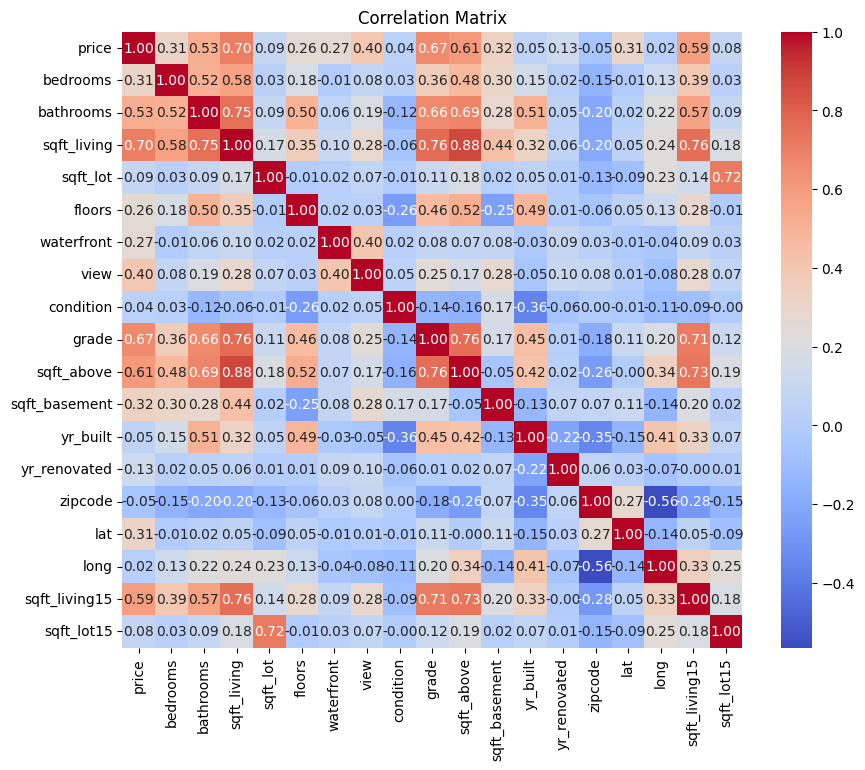

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [24]:
price_correlations = correlation_matrix["price"].sort_values(ascending=False)
print("The top features with the most correlation with Price:")
print(price_correlations[1:4])

The top features with the most correlation with Price:
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
Name: price, dtype: float64


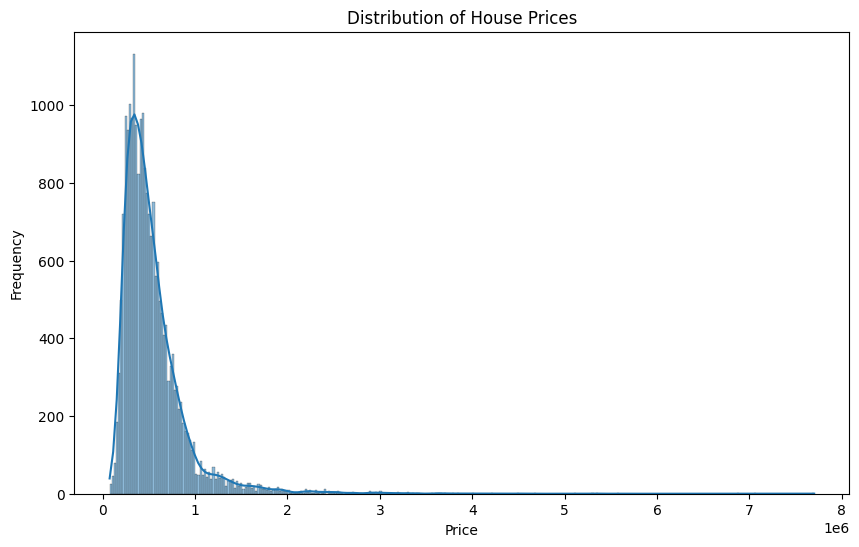

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

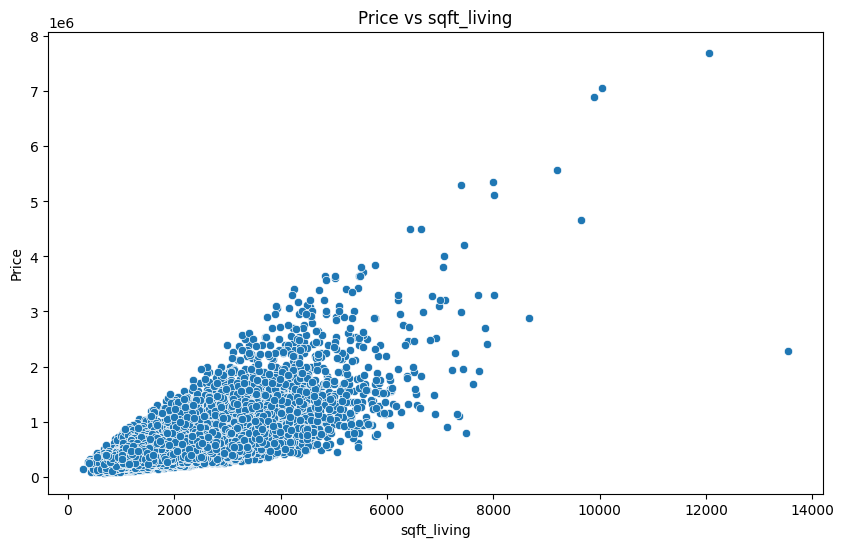

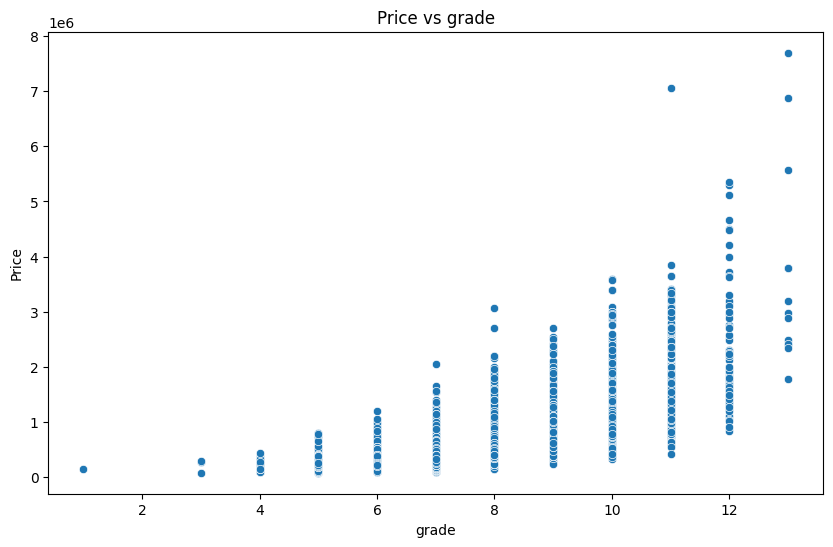

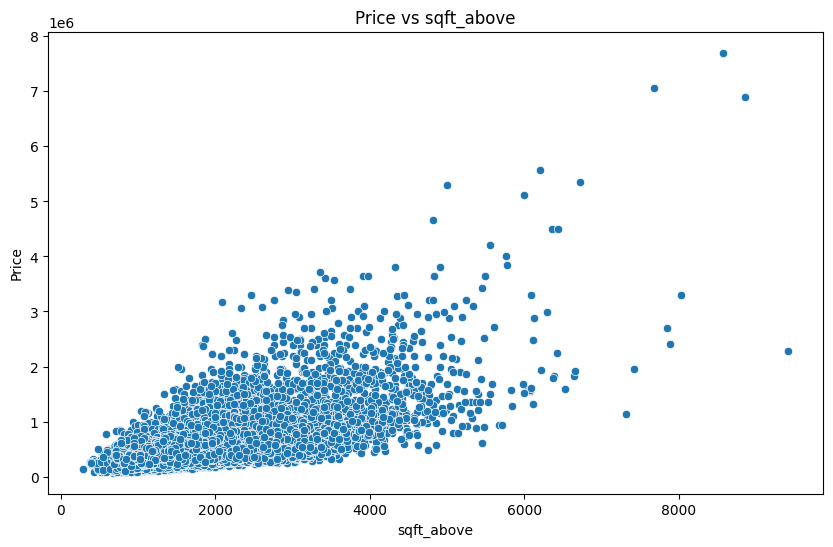

In [26]:
for i in range(1,4):
    top_feature = price_correlations.index[i] 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[top_feature], y=data['price'])
    plt.title(f"Price vs {top_feature}")
    plt.xlabel(top_feature)
    plt.ylabel("Price")
    plt.show()

In [27]:
data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y%m%dT%H%M%S')

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.drop(columns=['date'])
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,2
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,...,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,6
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,...,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,1


In [28]:
train_data, validation_data = train_test_split(data, test_size=0.25, random_state=42)

In [29]:
scaler = MinMaxScaler()
train_data_scaled = train_data.copy()
validation_data_scaled = validation_data.copy()

train_data_scaled[train_data.columns] = scaler.fit_transform(train_data)
validation_data_scaled[validation_data.columns] = scaler.transform(validation_data)

In [30]:
train_data_scaled

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
5945,0.025396,0.121212,0.28125,0.129252,0.007490,0.4,0.0,0.0,0.50,0.500000,...,0.000000,0.530435,0.0,0.272727,0.447841,0.275748,0.217002,0.009866,1.0,0.363636
8423,0.022295,0.090909,0.31250,0.111395,0.001948,0.4,0.0,0.0,0.75,0.500000,...,0.000000,0.800000,0.0,0.151515,0.394792,0.275748,0.227327,0.003393,0.0,0.545455
13488,0.016393,0.121212,0.31250,0.121599,0.006973,0.4,0.0,0.0,0.50,0.583333,...,0.000000,0.817391,0.0,0.010101,0.179686,0.171096,0.253141,0.007816,1.0,0.000000
20731,0.036393,0.060606,0.28125,0.080782,0.000159,0.4,0.0,0.0,0.50,0.500000,...,0.018672,0.947826,0.0,0.131313,0.602944,0.370432,0.144726,0.000114,1.0,0.272727
2358,0.020590,0.090909,0.25000,0.084184,0.011025,0.0,0.0,0.0,0.50,0.500000,...,0.000000,0.817391,0.0,0.207071,0.343199,0.369601,0.204956,0.008523,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.039738,0.090909,0.18750,0.060374,0.005492,0.0,0.0,0.0,0.50,0.500000,...,0.000000,0.408696,0.0,0.626263,0.897784,0.166113,0.103425,0.007232,0.0,0.909091
21575,0.042616,0.090909,0.31250,0.237840,0.003850,0.4,0.0,0.0,0.50,0.583333,...,0.000000,0.991304,0.0,0.111111,0.223354,0.141196,0.435037,0.005206,0.0,0.909091
5390,0.065574,0.090909,0.31250,0.155612,0.003659,0.4,0.0,0.0,0.50,0.500000,...,0.000000,0.904348,0.0,0.262626,0.843765,0.404485,0.222165,0.002296,0.0,0.727273
860,0.022295,0.030303,0.09375,0.007653,0.012437,0.0,0.0,0.0,0.50,0.333333,...,0.000000,0.547826,0.0,0.843434,0.520298,0.162791,0.132679,0.016483,0.0,0.454545


In [31]:
class HousePriceMLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes = list):
        super(HousePriceMLP, self).__init__()
        
        layers = []
        previous_size = input_size
        
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())
            previous_size = hidden_size

        layers.append(nn.Linear(previous_size, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)